In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer
from pyspark.sql.types import StringType, ArrayType, LongType
import re
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier

"""
if driver/workers detach, this download_dir may need changing:
  1. Run all as normal
  2. Check the error at the SentimentIntensityAnalyzer definition -> 'searched in' section of error
  3. Replace the download_dir with another 'local_disk0...' location that is currently being searched
Other directories may work but we have persisting errors attempting to download with 'nltk.download('vader_lexicon')', and other tested directories give 'Permission denied' issues
"""

#nltk.download('vader_lexicon)
nltk.download('vader_lexicon', download_dir='/local_disk0/.ephemeral_nfs/envs/pythonEnv-42892cb0-0b91-4a1f-8600-e55b5de1181d/nltk_data')

[nltk_data] Downloading package vader_lexicon to /local_disk0/.ephemer
[nltk_data]     al_nfs/envs/pythonEnv-42892cb0-0b91-4a1f-8600-e55b5de1
[nltk_data]     181d/nltk_data...


Out[1]: True

In [0]:
# LOAD AND UNDERSTAND THE DATA
spark = SparkSession.builder.appName("myApp").config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()

df = spark.read\
  .option("header", "true") \
  .option("inferSchema", "true") \
  .csv("/mnt/team8/dataset.csv")

df.printSchema()

root
 |-- Tweet ID: string (nullable = true)
 |-- Time Posted: string (nullable = true)
 |-- Tweet Content: string (nullable = true)
 |-- Publication: string (nullable = true)
 |-- Link: string (nullable = true)



In [0]:
# PREPROCESSING
df = df.drop("Link")
df.show()

+------------------+--------------------+--------------------+-----------+
|          Tweet ID|         Time Posted|       Tweet Content|Publication|
+------------------+--------------------+--------------------+-----------+
|585947808772960257|Wed Apr 08 23:30:...|GP workload harmi...|  bbchealth|
|585947807816650752|Wed Apr 08 23:30:...|Short people's 'h...|  bbchealth|
|585866060991078401|Wed Apr 08 18:05:...|New approach agai...|  bbchealth|
|585794106170839041|Wed Apr 08 13:19:...|Coalition 'underm...|  bbchealth|
|585733482413891584|Wed Apr 08 09:18:...|Review of case ag...|  bbchealth|
|585733481608646657|Wed Apr 08 09:18:...|VIDEO: 'All day i...|  bbchealth|
|585701601131765761|Wed Apr 08 07:11:...|VIDEO: 'Overhaul ...|  bbchealth|
|585620828110397440|Wed Apr 08 01:51:...|Care for dying 'n...|  bbchealth|
|585437294120677376|Tue Apr 07 13:41:...|VIDEO: NHS: Labou...|  bbchealth|
|585437293399252992|Tue Apr 07 13:41:...|Have GP services ...|  bbchealth|
|585376127931129857|Tue A

In [0]:
#split time posted column into 6 different time-related columns
df = df.withColumn("timestamp", F.to_timestamp(df["Time Posted"], "EEE MMM dd HH:mm:ss +0000 yyyy"))
df = df.withColumn("Year", df["timestamp"].substr(1, 4).cast("int"))
df = df.withColumn("Month", df["timestamp"].substr(6, 2).cast("int"))
df = df.withColumn("Day of Month", df["timestamp"].substr(9, 2).cast("int"))
df = df.withColumn("Hour", df["timestamp"].substr(12, 2).cast("int"))
df = df.withColumn("Minute", df["timestamp"].substr(15, 2).cast("int"))
df = df.withColumn("Second", df["timestamp"].substr(18, 2).cast("int"))
df.show()

+------------------+--------------------+--------------------+-----------+-------------------+----+-----+------------+----+------+------+
|          Tweet ID|         Time Posted|       Tweet Content|Publication|          timestamp|Year|Month|Day of Month|Hour|Minute|Second|
+------------------+--------------------+--------------------+-----------+-------------------+----+-----+------------+----+------+------+
|585947808772960257|Wed Apr 08 23:30:...|GP workload harmi...|  bbchealth|2015-04-08 23:30:18|2015|    4|           8|  23|    30|    18|
|585947807816650752|Wed Apr 08 23:30:...|Short people's 'h...|  bbchealth|2015-04-08 23:30:18|2015|    4|           8|  23|    30|    18|
|585866060991078401|Wed Apr 08 18:05:...|New approach agai...|  bbchealth|2015-04-08 18:05:28|2015|    4|           8|  18|     5|    28|
|585794106170839041|Wed Apr 08 13:19:...|Coalition 'underm...|  bbchealth|2015-04-08 13:19:33|2015|    4|           8|  13|    19|    33|
|585733482413891584|Wed Apr 08 09:

In [0]:
df = df.drop("Time Posted", "timestamp")
df.show(10)

+------------------+--------------------+-----------+----+-----+------------+----+------+------+
|          Tweet ID|       Tweet Content|Publication|Year|Month|Day of Month|Hour|Minute|Second|
+------------------+--------------------+-----------+----+-----+------------+----+------+------+
|585947808772960257|GP workload harmi...|  bbchealth|2015|    4|           8|  23|    30|    18|
|585947807816650752|Short people's 'h...|  bbchealth|2015|    4|           8|  23|    30|    18|
|585866060991078401|New approach agai...|  bbchealth|2015|    4|           8|  18|     5|    28|
|585794106170839041|Coalition 'underm...|  bbchealth|2015|    4|           8|  13|    19|    33|
|585733482413891584|Review of case ag...|  bbchealth|2015|    4|           8|   9|    18|    39|
|585733481608646657|VIDEO: 'All day i...|  bbchealth|2015|    4|           8|   9|    18|    39|
|585701601131765761|VIDEO: 'Overhaul ...|  bbchealth|2015|    4|           8|   7|    11|    58|
|585620828110397440|Care for d

In [0]:
tokenizer = nltk.tokenize.TweetTokenizer()

def tokenize_text(text):
    if isinstance(text, str):
        return tokenizer.tokenize(text)
    else:
        return []

tokenize_udf = udf(tokenize_text, ArrayType(StringType()))

# Apply the UDF to the 'Tweet Content' column and create a new column 'tokenized_words'
df = df.withColumn("tokenized_words", tokenize_udf("Tweet Content"))


# Show first 10 rows
df.select("tokenized_words").show(10, truncate=False)

+-----------------------------------------------------------------------+
|tokenized_words                                                        |
+-----------------------------------------------------------------------+
|[GP, workload, harming, care, -, BMA, poll]                            |
|[Short, people's, ', heart, risk, greater, ']                          |
|[New, approach, against, HIV, ', promising, ']                         |
|[Coalition, ', undermined, NHS, ', -, doctors]                         |
|[Review, of, case, against, NHS, manager]                              |
|[VIDEO, :, ', All, day, is, empty, ,, what, am, I, going, to, do, ?, ']|
|[VIDEO, :, ', Overhaul, needed, ', for, end-of-life, care]             |
|[Care, for, dying, ', needs, overhaul, ']                              |
|[VIDEO, :, NHS, :, Labour, and, Tory, key, policies]                   |
|[Have, GP, services, got, worse, ?]                                    |
+-------------------------------------

In [0]:
# define the stemmer to use in preprocessing
stemmer = SnowballStemmer(language='english')


# Define a UDF to apply stemming, lemmatization and removing punctuation/converting to lowercase over tokenized_words
def stem_words(tokens):
  return [stemmer.stem(token) for token in tokens]

stem_words_udf = F.udf(stem_words, ArrayType(StringType()))

# Apply the UDF on tokenized column
df = df.withColumn("stemmed_words", stem_words_udf(F.col("tokenized_words")))

# Display the first 5 rows of the preprocessed content
df.show(5, truncate=False)

+------------------+------------------------------------+-----------+----+-----+------------+----+------+------+----------------------------------------------+-------------------------------------------+
|Tweet ID          |Tweet Content                       |Publication|Year|Month|Day of Month|Hour|Minute|Second|tokenized_words                               |stemmed_words                              |
+------------------+------------------------------------+-----------+----+-----+------------+----+------+------+----------------------------------------------+-------------------------------------------+
|585947808772960257|GP workload harming care - BMA poll |bbchealth  |2015|4    |8           |23  |30    |18    |[GP, workload, harming, care, -, BMA, poll]   |[gp, workload, harm, care, -, bma, poll]   |
|585947807816650752|Short people's 'heart risk greater' |bbchealth  |2015|4    |8           |23  |30    |18    |[Short, people's, ', heart, risk, greater, '] |[short, peopl, ', heart, 

In [0]:
#lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]

# define a lemmatizer to apply general english language rules to the text for the lemmatized versions
def lemmatize(word_list):
    lemmatized_list = []
    for word in word_list:
        if word.endswith('s'):
            if word.endswith('ss'):
                lemmatized_word = word
            elif word.endswith('ies'):
                lemmatized_word = word[:-3] + 'y'
            else:
                lemmatized_word = word[:-1]
        elif word.endswith('ing'):
            if len(word) > 5:
                if word[-4] == word[-5]:
                    lemmatized_word = word[:-4]
                else:
                    lemmatized_word = word[:-3] + 'e'
            else:
                lemmatized_word = word[:-3]
        elif word.endswith('ed'):
            if len(word) > 4:
                if word[-3] == word[-4]:
                    lemmatized_word = word[:-3]
                else:
                    lemmatized_word = word[:-2] + 'e'
            else:
                lemmatized_word = word[:-2]
        else:
            lemmatized_word = word
        lemmatized_list.append(lemmatized_word)
    return lemmatized_list

# define lemmatized words udf and apply it to the column of stemmed words
lemmatize_udf = udf(lemmatize, ArrayType(StringType()))

df = df.withColumn('lemmatized_words', lemmatize_udf(df['stemmed_words']))

In [0]:
# define the regex to remove punctuation
pattern = re.compile('[^\w\s]')

# apply the regex pattern and make all words lowercase
def no_punc_lower_words(words):
  return [pattern.sub('', word.lower()) for word in words]

# define a udf for no punctuation and lowercase words and apply this to the column of lemmatized words
no_punc_lower_udf = udf(no_punc_lower_words, StringType())

df = df.withColumn('no_punc_lower_words', no_punc_lower_udf(df['lemmatized_words']))

In [0]:
# create an instance of the vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# define UDF to apply the vader_lexicon model to each no_punc_lower_words list and return the sentiment result
def analyze_sentiment(words):
    scores = analyzer.polarity_scores(' '.join(words))
    if scores['compound'] >= 0:
        return 'Positive'
    else:
        return 'Negative'

# define the udf for the sentiment and apply it to the no_punc_lower_words column for the final sentiment labels
analyze_sentiment_udf = F.udf(analyze_sentiment, StringType())

df = df.withColumn("Sentiment", analyze_sentiment_udf(F.col("no_punc_lower_words")))

In [0]:
df = df.drop("tokenized_words", 'stemmed_words', 'lemmatized_words', 'no_punc_lower_words')
df.show(10)

+------------------+--------------------+-----------+----+-----+------------+----+------+------+---------+
|          Tweet ID|       Tweet Content|Publication|Year|Month|Day of Month|Hour|Minute|Second|Sentiment|
+------------------+--------------------+-----------+----+-----+------------+----+------+------+---------+
|585947808772960257|GP workload harmi...|  bbchealth|2015|    4|           8|  23|    30|    18| Negative|
|585947807816650752|Short people's 'h...|  bbchealth|2015|    4|           8|  23|    30|    18| Positive|
|585866060991078401|New approach agai...|  bbchealth|2015|    4|           8|  18|     5|    28| Positive|
|585794106170839041|Coalition 'underm...|  bbchealth|2015|    4|           8|  13|    19|    33| Positive|
|585733482413891584|Review of case ag...|  bbchealth|2015|    4|           8|   9|    18|    39| Positive|
|585733481608646657|VIDEO: 'All day i...|  bbchealth|2015|    4|           8|   9|    18|    39| Positive|
|585701601131765761|VIDEO: 'Overhaul 

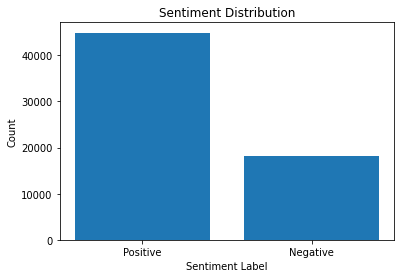

In [0]:
# Count the number of each sentiment label
sentiment_counts = df.groupBy('Sentiment').count().collect()

# Extract the counts and labels into separate lists
labels = [row['Sentiment'] for row in sentiment_counts]
counts = [row['count'] for row in sentiment_counts]

# Create a bar graph
fig, ax = plt.subplots()
ax.bar(labels, counts)
ax.set_title('Sentiment Distribution')
ax.set_xlabel('Sentiment Label')
ax.set_ylabel('Count')
plt.show()

In [0]:
# splits the data into 70% for the training set and 30% for the testing set, with a random seed of 134
train_data, test_data = df.randomSplit([0.7, 0.3], seed=134)

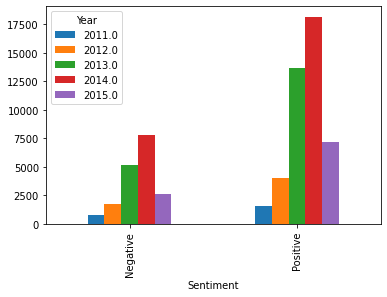

In [0]:
# VISUALISATION
pdf = df.toPandas()

# Group by month and sentiment
grouped = pdf.groupby(['Year', 'Sentiment']).size().reset_index(name='count')

# Pivot the table to have months as columns and sentiments as rows
pivoted = grouped.pivot(index='Sentiment', columns='Year', values='count')

# Create a bar plot
pivoted.plot(kind='bar')
plt.show()

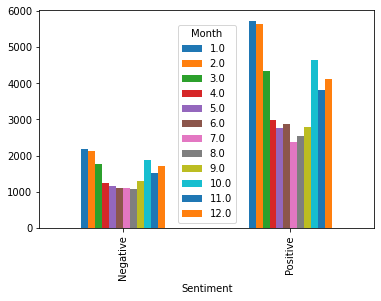

In [0]:
# Group by month and sentiment
grouped = pdf.groupby(['Month', 'Sentiment']).size().reset_index(name='count')

# Pivot the table to have months as columns and sentiments as rows
pivoted = grouped.pivot(index='Sentiment', columns='Month', values='count')

# Create a bar plot
pivoted.plot(kind='bar')
plt.show()

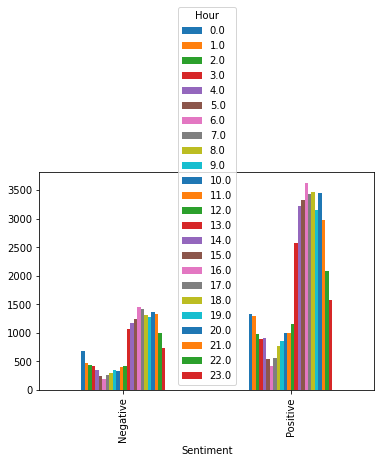

In [0]:
# Group by hour and sentiment
grouped = pdf.groupby(['Hour', 'Sentiment']).size().reset_index(name='count')

# Pivot the table to have hours as columns and sentiments as rows
pivoted = grouped.pivot(index='Sentiment', columns='Hour', values='count')

# Create a bar plot
pivoted.plot(kind='bar')
plt.show()

In [0]:
# filter any rows for which the Publication column contains an invalid value
options = ['bbchealth', 'cbchealth', 'cnnhealth', 'everydayhealth', 'foxnewshealth', \
  'gdnhealthcare', 'goodhealth', 'kaiserhealthnews', 'latimeshealth', 'msnhealthnews'\
  , 'nbchealth', 'nprhealth', 'nytimeshealth', 'reutershealth', 'usnewshealth', \
  'wsjhealth',]

df = df.filter(df['Publication'].isin(options))

unique_values = df.select('Publication').distinct().rdd.map(lambda r: r[0]).collect()
print(unique_values)

['cbchealth', 'goodhealth', 'foxnewshealth', 'gdnhealthcare', 'bbchealth', 'everydayhealth', 'cnnhealth', 'nbchealth', 'latimeshealth', 'kaiserhealthnews', 'msnhealthnews', 'nprhealth', 'nytimeshealth', 'reutershealth', 'wsjhealth', 'usnewshealth']


In [0]:
# Group the data by 'Publication' and 'Sentiment' and count the number of rows in each group
grouped_df = df.groupBy('Publication', 'Sentiment').agg(F.count('*').alias('count'))

# Sort the data by the order of the publications
grouped_df_ordered = grouped_df.orderBy(F.when(F.col('Publication').isin(options), F.col('Publication')).otherwise(F.lit('ZZZ')))

# Use the 'display' function to create a stacked bar chart
display(grouped_df_ordered, x='Publication', y='count', z='Sentiment', kind='bar', stacked=True)

# Show the positive to negative ratio in the sentiment column for comparison
grouped_df = df.groupBy('Sentiment').agg(F.count('*').alias('count'))

# Pivot the data to count the number of 'Positive' and 'Negative' instances separately
pivoted_df = grouped_df.groupBy().pivot('Sentiment', ['Positive', 'Negative']).sum('count')

# Calculate the ratio of 'Positive' to 'Negative' instances
positive_count = pivoted_df.select('Positive').collect()[0][0]
negative_count = pivoted_df.select('Negative').collect()[0][0]
positive_to_negative_ratio = positive_count / negative_count

print('Positive to Negative Ratio: {:.2f}'.format(positive_to_negative_ratio))

Publication,Sentiment,count
bbchealth,Negative,1240
bbchealth,Positive,2688
cbchealth,Negative,1343
cbchealth,Positive,2377
cnnhealth,Positive,2773
cnnhealth,Negative,1241
everydayhealth,Negative,774
everydayhealth,Positive,2455
foxnewshealth,Negative,726
foxnewshealth,Positive,1273


Positive to Negative Ratio: 2.45


In [0]:
## Create a Pipeline with Spark ML

# Convert string columns to numeric type
labelIndexer = StringIndexer(inputCol="Sentiment", outputCol="label", handleInvalid="keep")
df = labelIndexer.fit(df).transform(df)
df = df.drop("Sentiment")

In [0]:
df = df.withColumn("Tweet ID", F.col("Tweet ID").cast(LongType()))

In [0]:
for c in ["Tweet Content", "Publication"]:
    indexer = StringIndexer(inputCol=c, outputCol=c+"_num", handleInvalid="keep").fit(df)
    df = indexer.transform(df).drop(c)

# One-hot encode Publication and Sentiment columns
encoder1 = OneHotEncoder(inputCol="Publication_num", outputCol="Publication_vec", handleInvalid="keep")

# Create feature vector
feature_cols = df.columns
feature_cols.remove('label')

vectorAssembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")

In [0]:
df.show(1000)

In [0]:
# Train Naive Bayes model
nb = NaiveBayes(modelType="multinomial", labelCol="label", featuresCol="features")

In [0]:
# Create parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
    .build()

In [0]:
# Evaluate model using accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

In [0]:
cv = CrossValidator(estimator=nb, estimatorParamMaps=paramGrid, evaluator=evaluator)

In [0]:
# Chain indexers and model in a Pipeline
pipeline = Pipeline(stages=[indexer, encoder1, vectorAssembler, cv])

In [0]:
pipelineModel = pipeline.fit(df)

In [0]:
"Extracting feature importances so we can drop less important features"
cvModel = pipelineModel.stages[1]
pairs = cvModel.bestModel.featureImportances

for i in zip(df.columns, pairs):
    if i[1] <= 0 and i[0] != 'label':
        #df = df.drop(i[0])
        print("Removing:", i)
    else:
        print("Keeping:", i)

In [0]:
"""There is no feature importance function in Naive Bayes so trying gradient descent/random forest"""

"""Created a new vector assembler because our 7th feature had too many categorical values and it had to be dropped"""
# Identify the index of the problematic categorical feature (assuming it's the 7th feature)
cat_feature_index = 7

# Drop the problematic categorical feature
feature_cols = [c for c in df.columns if c not in ["label", "Publication_num", "Sentiment_num"]]
feature_cols.pop(cat_feature_index)

# Create a new VectorAssembler with the updated feature columns
vectorAssembler2 = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="keep")

In [0]:
gbt = GBTClassifier(labelCol="label", maxBins=60000)

paramGrid2 = ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [5, 8])\
  .addGrid(gbt.maxIter, [10, 100])\
  .build()

evaluator2 = MulticlassClassificationEvaluator(metricName='f1', labelCol="label")

cv2 = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid2, evaluator=evaluator2, numFolds=5, parallelism=4)
pipeline2 = Pipeline(stages=[indexer, vectorAssembler2, cv2])

In [0]:
pipelineModel2 = pipeline2.fit(df)

In [0]:
"Extracting feature importances so we can drop less important features"
cvModel = pipelineModel2.stages[1]
pairs = cvModel.bestModel.featureImportances

for i in zip(df.columns, pairs):
    if i[1] <= 0 and i[0] != 'label':
        #df = df.drop(i[0])
        print("Removing:", i)
    else:
        print("Keeping:", i)

In [0]:
df.unpersist()

In [0]:
spark.stop()

/databricks/spark/python/pyspark/context.py:698: RuntimeWarning: Unable to cleanly shutdown Spark JVM process. It is possible that the process has crashed, been killed or may also be in a zombie state.
  warnings.warn(
